# Model Evaluation

This notebook evaluates the final trained model on the test set.

**Pipeline:**
- Load the trained model from `2_TrainBestModel.ipynb`
- Evaluate on test set
- Generate comprehensive evaluation metrics
- Create visualizations

# Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
import math
import copy
import warnings

from itertools import cycle

# Setup Paths

In [2]:
project_dir_path = "/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/"
temp_files_path = project_dir_path + 'TempFiles/'

# Load Dataset

In [3]:
# ============================================================
# LOAD DATASET
# ============================================================

import pickle

print("Loading dataset...")
save_path = temp_files_path
file_name = 'traintest_data4.pkl'  # Updated to match 2_TrainBestModel.ipynb

with open(save_path + file_name, 'rb') as f:
    PROCESSED_DATASET = pickle.load(f)

(   X_train, X_test, 
    period_train, period_test, 
    y_train, y_test, 
    feature_cols,
    train_cluster_names, test_cluster_names) = PROCESSED_DATASET

print("\n" + "="*70)
print("DATASET LOADED")
print("="*70)
print(f"Training set:   {X_train.shape[0]} samples")
print(f"Test set:       {X_test.shape[0]} samples")
print(f"Features:       {X_train.shape[1]} summary statistics")
print(f"Periodogram:    {period_train.shape[1]} frequency bins")
print(f"\nTrain clusters: {len(np.unique(train_cluster_names))} unique clusters")
print(f"Test clusters:  {len(np.unique(test_cluster_names))} unique clusters")
print("\n⚠️  NOTE: Data is RAW (unscaled). We'll use preprocessed data from model package.")
print("="*70)

Loading dataset...

DATASET LOADED
Training set:   3972 samples
Test set:       436 samples
Features:       17 summary statistics
Periodogram:    1089 frequency bins

Train clusters: 313 unique clusters
Test clusters:  35 unique clusters

⚠️  NOTE: Data is RAW (unscaled). We'll use preprocessed data from model package.


# Load Model Architecture and Helper Functions

In [4]:
# Load model class definition
import sys
sys.path.append(project_dir_path)

from GaussianNN_wPeriodogram import DualInputNN

In [8]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

# Import evaluation functions
from DataAnalysis_HelperFcns import (
    mae, rmse, coverage, crps_gaussian, Loss_Components
)

from SingleFold_PlottingFcns import (
    SummaryStats, PlotSummaryStats
)

# Import NEW model evaluation plotting functions
from ModelEvaluation_PlottingFcns import (
    # Core Performance Plots
    plot_prediction_vs_truth,
    plot_residuals_analysis,
    plot_residuals_simple,
    # Summary Metrics
    compute_summary_metrics,
    print_metrics_table,
    plot_metrics_comparison,
    # Uncertainty Calibration Plots
    plot_zscore_analysis,
    plot_coverage_calibration,
    plot_uncertainty_distribution
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Trained Model

In [ ]:
# ============================================================
# LOAD TRAINED MODEL
# ============================================================

model_path = temp_files_path + 'final_model.pt'

print("Loading trained model...")
model_package = torch.load(model_path)

# Extract model components
hyperparameters = model_package['hyperparameters']
model_architecture = model_package['model_architecture']
training_log = model_package['training_log']
best_epoch = model_package['best_epoch_from_tuning']
composite_score = model_package['composite_score']

# Check if we have best_model_epoch info
best_model_epoch = model_package.get('best_model_epoch', None)

# Display model information
print("\n" + "="*70)
print("TRAINED MODEL LOADED")
print("="*70)
print(f"Best epoch (from tuning): {best_epoch}")
print(f"Composite score:          {composite_score:.4f}")

if best_model_epoch is not None:
    print(f"\n💡 This model is from epoch {best_model_epoch} (best smoothed val loss)")

print(f"\nModel Architecture:")
print(f"  Summary stats dim:      {model_architecture['summary_dim']}")
print(f"  Periodogram dim:        {model_architecture['periodogram_dim']}")
print(f"  Hidden layer size:      {model_architecture['hidden_size']}")
print(f"  Dropout probability:    {model_architecture['dropout_prob']}")
print(f"  Use periodogram:        {model_architecture['use_periodogram']}")
print(f"  Use CNN:                {model_architecture['use_cnn']}")
print(f"  Learn sigma:            {model_architecture['learn_sigma']}")
print("\nHyperparameters:")
for key, value in hyperparameters.items():
    print(f"  {key:30s} = {value}")
print("="*70)

# Reconstruct Model from Saved Weights

In [10]:
# ============================================================
# RECONSTRUCT MODEL
# ============================================================

print("Reconstructing model from saved weights...")

# Initialize model with saved architecture
final_model = DualInputNN(
    summary_dim=model_architecture['summary_dim'],
    periodogram_dim=model_architecture['periodogram_dim'],
    x1=model_architecture['hidden_size'],
    dropout_prob=model_architecture['dropout_prob'],
    use_periodogram=model_architecture['use_periodogram'],
    periodogram_use_cnn=model_architecture['use_cnn'],
    learn_sigma=model_architecture['learn_sigma']
)

# Load trained weights
final_model.load_state_dict(model_package['model_state_dict'])

# Set to evaluation mode
final_model.eval()

print("\n✅ Model reconstructed and ready for evaluation!")
print(f"   Model is in evaluation mode (dropout disabled)")
print("="*70)

Reconstructing model from saved weights...

✅ Model reconstructed and ready for evaluation!
   Model is in evaluation mode (dropout disabled)


# Apply Preprocessing from Saved Model

In [11]:
# ============================================================
# APPLY PREPROCESSING FROM MODEL PACKAGE
# ============================================================

print("\n" + "="*70)
print("APPLYING PREPROCESSING")
print("="*70)

# Extract preprocessing objects from model package
SCALER = model_package['scaler']
y_mean = model_package['y_mean']
mean_peak_strength = model_package['mean_peak_strength']

print(f"\nPreprocessing parameters from trained model:")
print(f"  y_mean (target mean):              {y_mean:.4f}")
print(f"  mean_peak_strength (periodogram):  {mean_peak_strength:.6f}")
print(f"  Scaler mean (first 3 features):    {SCALER.mean_[:3]}")

# Apply preprocessing to training data
print("\nPreprocessing TRAINING data...")
X_train_scaled = torch.tensor(
    SCALER.transform(X_train.cpu().numpy()),
    dtype=torch.float32
)
y_train_demeaned = y_train - y_mean
period_train_norm = period_train / mean_peak_strength

# Apply preprocessing to test data
print("Preprocessing TEST data...")
X_test_scaled = torch.tensor(
    SCALER.transform(X_test.cpu().numpy()),
    dtype=torch.float32
)
y_test_demeaned = y_test - y_mean
period_test_norm = period_test / mean_peak_strength

print("\n✅ Preprocessing complete!")
print(f"   Train X range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"   Test X range:  [{X_test_scaled.min():.3f}, {X_test_scaled.max():.3f}]")
print(f"   Train y range: [{y_train_demeaned.min():.3f}, {y_train_demeaned.max():.3f}]")
print(f"   Test y range:  [{y_test_demeaned.min():.3f}, {y_test_demeaned.max():.3f}]")
print("="*70)


APPLYING PREPROCESSING

Preprocessing parameters from trained model:
  y_mean (target mean):              7.9401
  mean_peak_strength (periodogram):  0.194169
  Scaler mean (first 3 features):    [0.12137704 0.0009853  0.00064799]

Preprocessing TRAINING data...
Preprocessing TEST data...

✅ Preprocessing complete!
   Train X range: [-1.630, 58.808]
   Test X range:  [-1.630, 13.050]
   Train y range: [-1.540, 2.160]
   Test y range:  [-0.640, 2.160]


# Generate Predictions on Train and Test Sets

In [12]:
# ============================================================
# GENERATE PREDICTIONS
# ============================================================

print("\n" + "="*70)
print("GENERATING PREDICTIONS")
print("="*70)

# Set model to evaluation mode (disable dropout)
final_model.eval()

with torch.no_grad():
    # Train set predictions (using SCALED/PREPROCESSED data)
    print("\nGenerating predictions on TRAINING set...")
    y_pred_train_demeaned, sigma_pred_train = final_model(X_train_scaled, period_train_norm)
    
    # Add back the mean to get predictions in original scale
    y_pred_train = y_pred_train_demeaned + y_mean
    
    print(f"  ✅ Train predictions: {y_pred_train.shape}")
    print(f"     Age range: [{y_pred_train.min():.3f}, {y_pred_train.max():.3f}]")
    print(f"     Sigma range: [{sigma_pred_train.min():.3f}, {sigma_pred_train.max():.3f}]")
    
    # Test set predictions (using SCALED/PREPROCESSED data)
    print("\nGenerating predictions on TEST set...")
    y_pred_test_demeaned, sigma_pred_test = final_model(X_test_scaled, period_test_norm)
    
    # Add back the mean to get predictions in original scale
    y_pred_test = y_pred_test_demeaned + y_mean
    
    print(f"  ✅ Test predictions: {y_pred_test.shape}")
    print(f"     Age range: [{y_pred_test.min():.3f}, {y_pred_test.max():.3f}]")
    print(f"     Sigma range: [{sigma_pred_test.min():.3f}, {sigma_pred_test.max():.3f}]")

print("\n" + "="*70)
print("✅ Predictions complete!")
print("  Note: Predictions have been converted back to original scale")
print("="*70)


GENERATING PREDICTIONS

Generating predictions on TRAINING set...
  ✅ Train predictions: torch.Size([3972, 1])
     Age range: [6.995, 11.263]
     Sigma range: [0.069, 8.655]

Generating predictions on TEST set...
  ✅ Test predictions: torch.Size([436, 1])
     Age range: [7.063, 14.526]
     Sigma range: [0.125, 12.711]

✅ Predictions complete!
  Note: Predictions have been converted back to original scale


# Compute Summary Metrics

In [13]:
# ============================================================
# COMPUTE SUMMARY METRICS
# ============================================================

print("Computing metrics...")

# Compute metrics for train and test sets
train_metrics = compute_summary_metrics(y_train, y_pred_train, sigma_pred_train)
test_metrics = compute_summary_metrics(y_test, y_pred_test, sigma_pred_test)

# Print comparison table
print_metrics_table(train_metrics, test_metrics)

Computing metrics...

MODEL EVALUATION METRICS SUMMARY
Metric                          Train Set        Test Set      Difference
--------------------------------------------------------------------------------
MAE                                0.3041          0.4730          0.1688
RMSE                               0.4300          0.7458          0.3159
Median Error                       0.2188          0.3271          0.1083
Max Error                          2.2042          5.4907          3.2865
Mean Residual                     -0.0268         -0.0342         -0.0074
Median Residual                   -0.0152          0.0417          0.0569
Coverage@68%                       0.7754          0.6170         -0.1585
Coverage@95%                       0.9748          0.9335         -0.0413
Coverage@99%                       0.9977          0.9702         -0.0276
CRPS                               0.2118          0.3320          0.1203
Mean Sigma                         0.4215         

# Visualization: Metrics Comparison Bar Plot

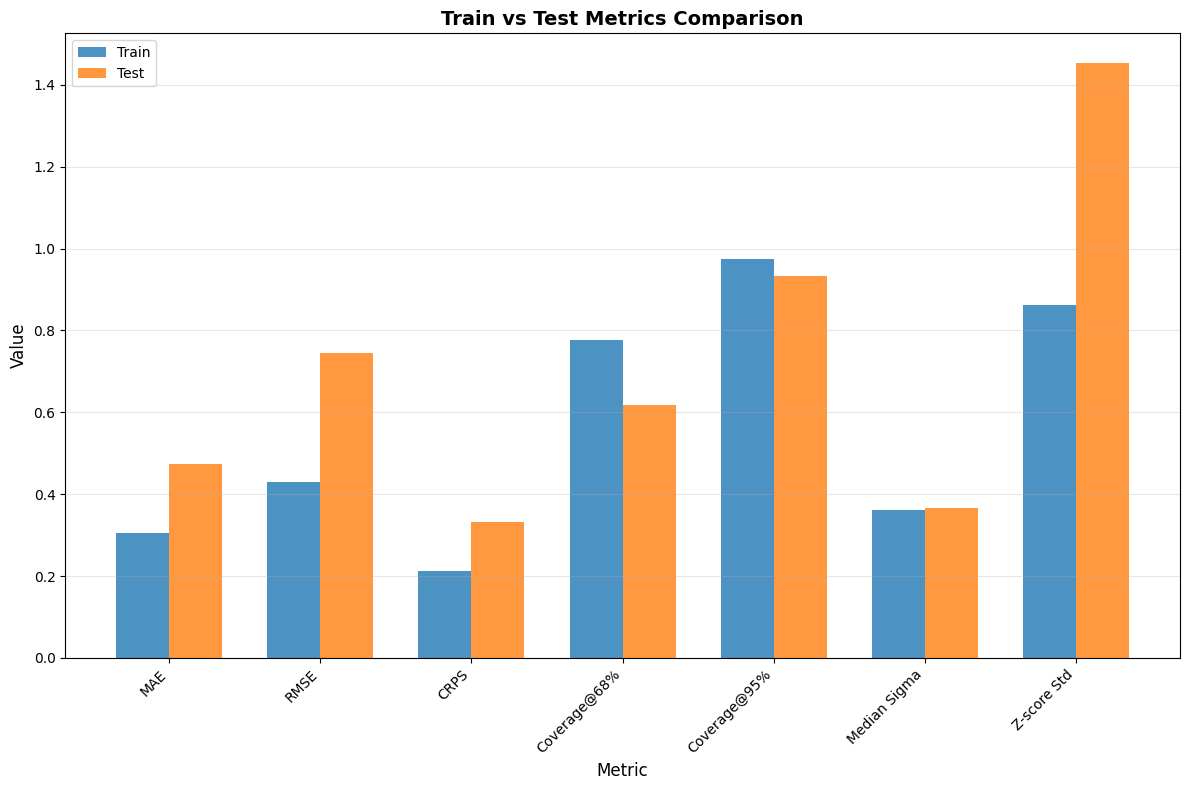

In [14]:
# Plot metrics comparison
fig, ax = plot_metrics_comparison(train_metrics, test_metrics)
plt.show()

# Core Performance Plots: Predicted vs True Age

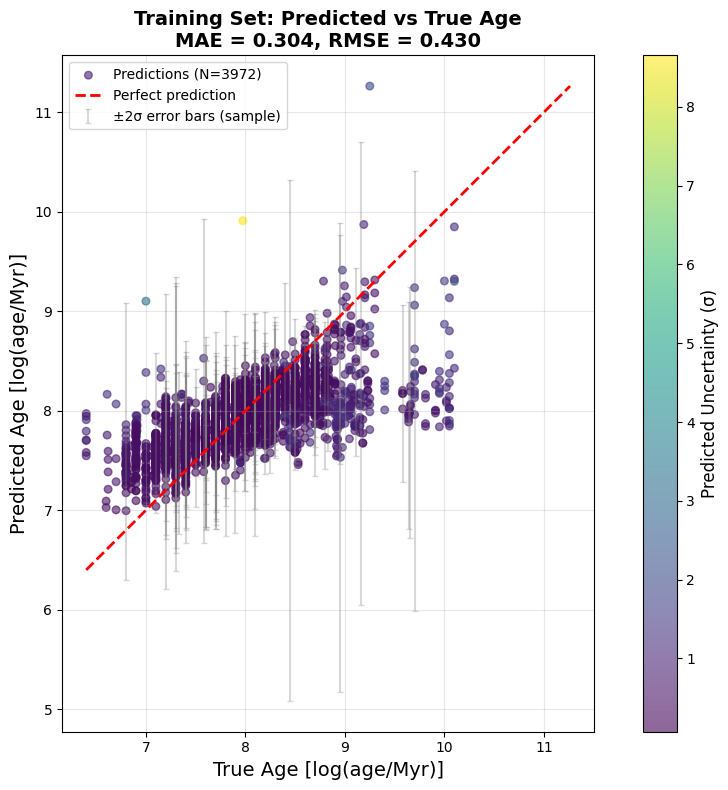

In [15]:
# ============================================================
# PREDICTED VS TRUE AGE - TRAINING SET
# ============================================================

fig, ax = plot_prediction_vs_truth(
    y_train, y_pred_train, sigma_pred_train,
    dataset_label='Training Set',
    show_errorbars=True,
    color_by_uncertainty=True
)
plt.show()

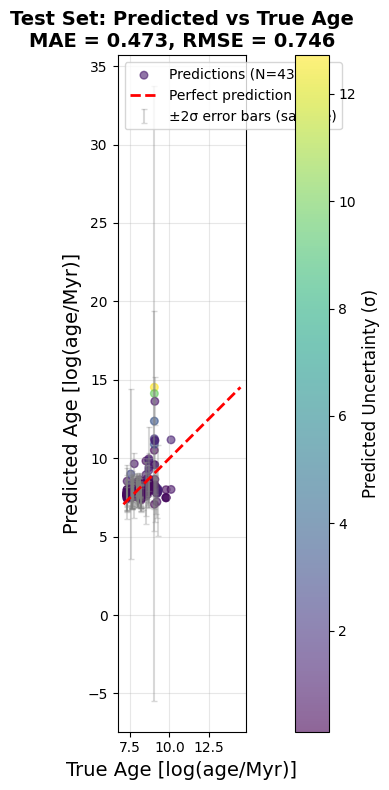

In [16]:
# ============================================================
# PREDICTED VS TRUE AGE - TEST SET
# ============================================================

fig, ax = plot_prediction_vs_truth(
    y_test, y_pred_test, sigma_pred_test,
    dataset_label='Test Set',
    show_errorbars=True,
    color_by_uncertainty=True
)
plt.show()

# Residual Analysis

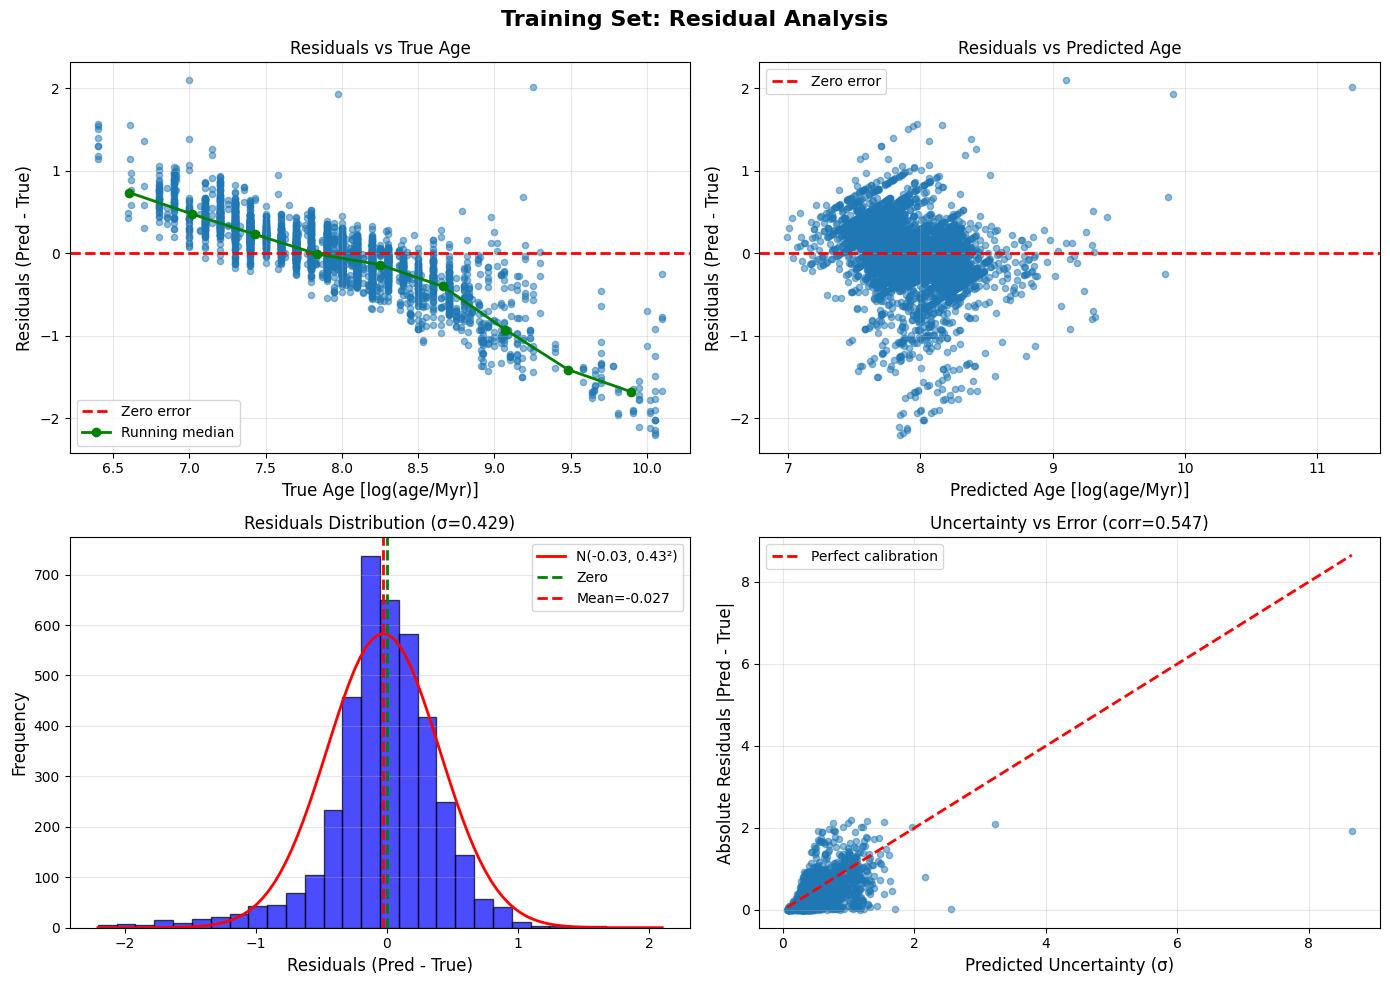

In [17]:
# ============================================================
# RESIDUAL ANALYSIS - TRAINING SET
# ============================================================

fig, axs = plot_residuals_analysis(
    y_train, y_pred_train, sigma_pred_train,
    dataset_label='Training Set'
)
plt.show()

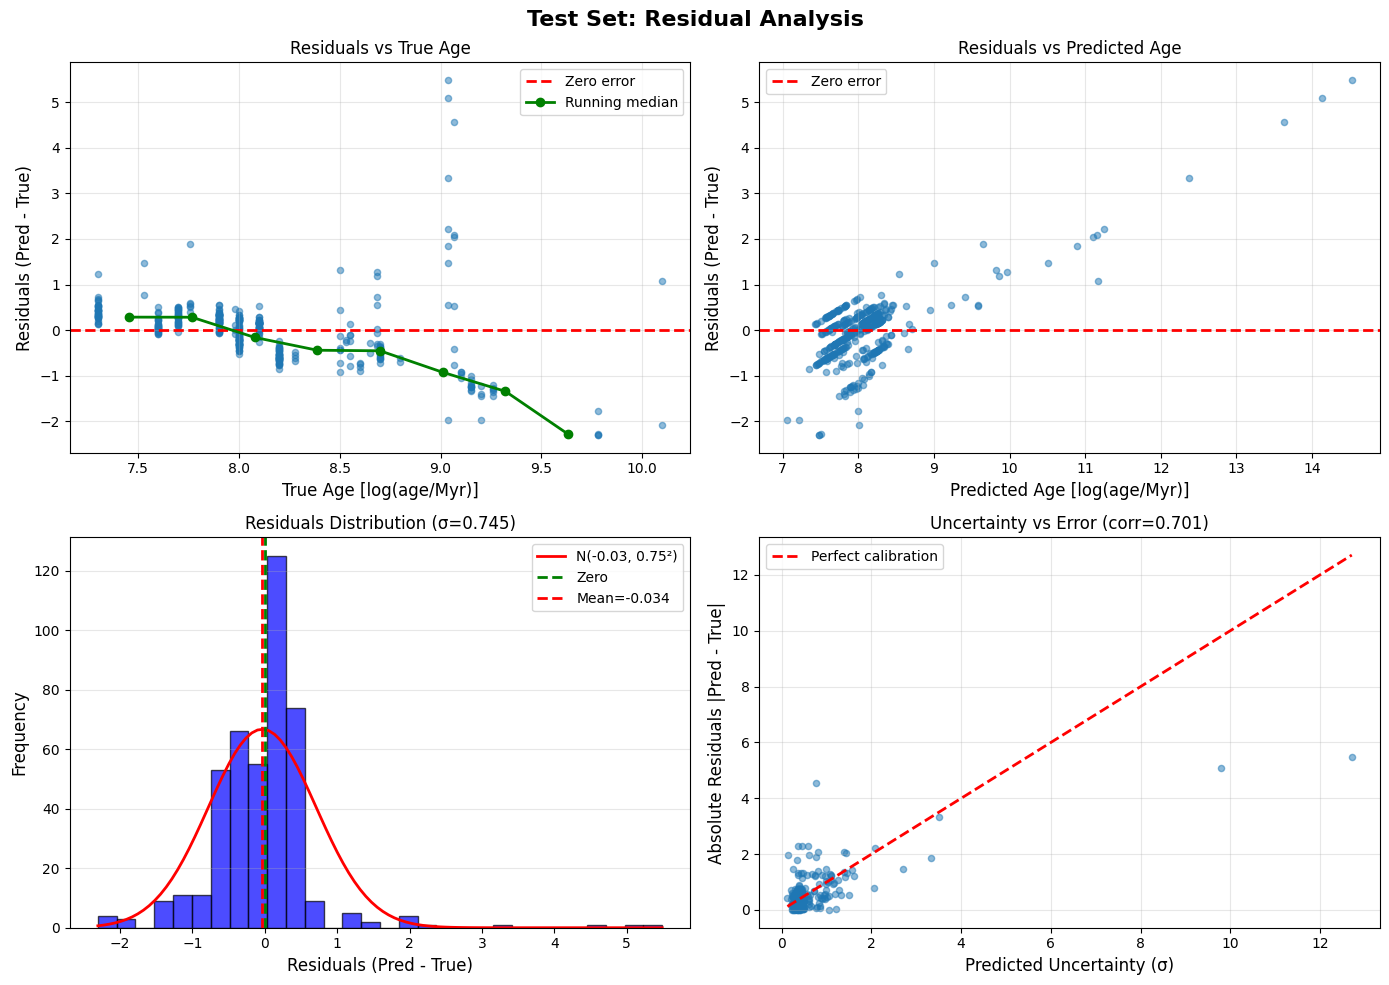

In [18]:
# ============================================================
# RESIDUAL ANALYSIS - TEST SET
# ============================================================

fig, axs = plot_residuals_analysis(
    y_test, y_pred_test, sigma_pred_test,
    dataset_label='Test Set'
)
plt.show()

# Uncertainty Calibration Analysis

In [ ]:
# ============================================================
# Z-SCORE ANALYSIS - TEST SET
# ============================================================

fig, axs, z_scores, ks_stat, ks_p = plot_zscore_analysis(
    y_test, y_pred_test, sigma_pred_test,
    dataset_label='Test Set'
)
plt.show()

print(f"\nZ-Score Statistics:")
print(f"  Mean: {z_scores.mean():.4f} (ideal: 0)")
print(f"  Std:  {z_scores.std():.4f} (ideal: 1)")
print(f"  KS test statistic: {ks_stat:.4f}")
print(f"  KS test p-value:   {ks_p:.4f}")
if ks_p > 0.05:
    print(f"  ✅ Cannot reject that z-scores are N(0,1) distributed (p > 0.05)")
else:
    print(f"  ⚠️  Z-scores significantly deviate from N(0,1) (p < 0.05)")

In [ ]:
# ============================================================
# COVERAGE CALIBRATION CURVE - TEST SET
# ============================================================

fig, ax, coverage_dict = plot_coverage_calibration(
    y_test, y_pred_test, sigma_pred_test,
    dataset_label='Test Set'
)
plt.show()

print(f"\nCoverage at Key Confidence Levels:")
conf_levels = coverage_dict['confidence_levels']
emp_coverage = coverage_dict['empirical_coverage']
for level in [0.50, 0.68, 0.95, 0.99]:
    idx = np.argmin(np.abs(conf_levels - level))
    empirical = emp_coverage[idx]
    error = empirical - level
    print(f"  {level:.0%}: Empirical={empirical:.2%}, Error={error:+.2%}")

In [ ]:
# ============================================================
# UNCERTAINTY DISTRIBUTION - TRAIN VS TEST
# ============================================================

fig, axs = plot_uncertainty_distribution(
    sigma_pred_train, sigma_pred_test
)
plt.show()

# Next Steps: Performance Breakdown & Advanced Analysis (To Be Implemented)

The following evaluation plots remain to be added:

**Performance Breakdown Plots:**
- Error metrics by age bin (young/intermediate/old clusters) - MAE, RMSE across age ranges
- Coverage by age bin - Check if calibration holds uniformly across ages
- Performance by individual cluster - Identify best/worst predicted clusters

**Optional Advanced Analysis:**
- MC Dropout uncertainty decomposition (aleatoric vs epistemic uncertainty)
- Feature importance via permutation - Which features drive predictions?